In [2]:
!git clone -b main https://github.com/StarkitRobots/cvr_course

Cloning into 'cvr_course'...
remote: Enumerating objects: 506, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 506 (delta 2), reused 10 (delta 2), pack-reused 491
Receiving objects: 100% (506/506), 60.36 MiB | 34.68 MiB/s, done.
Resolving deltas: 100% (109/109), done.


#Task 1#
1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

In [3]:
cd cvr_course


/content/cvr_course


In [4]:
import numpy as np
import cv2
import glob
import shapely.geometry as geom
from matplotlib import pyplot as plt

In [19]:
def show_files(file):
  return cv2.cvtColor (file, cv2.COLOR_BGR2RGB)
img_files = glob.glob('data/imgs/arrow/*')
len(img_files)

10

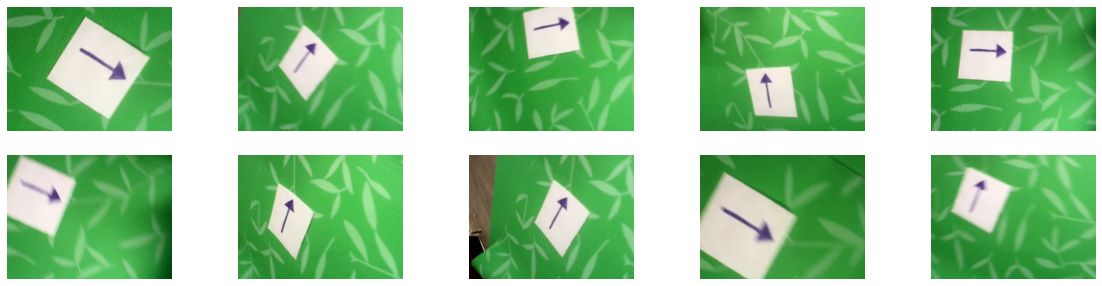

In [20]:
images = []
plt.figure(figsize=(20, 5))
for ind, img_file in enumerate(img_files):
  plt.subplot(2, 5, ind+1)
  img = cv2.imread(img_file)
  images.append(img)
  plt.imshow(show_files(img))
  plt.axis('off')
plt.show ()

#Task 2#
1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

In [26]:
def find_contour (img, low_th, high_th):
    img_rgb = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)

    mask = cv2.inRange (img, low_th, high_th)
    contours, hierarchy = cv2.findContours (mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = None

    max_len = -1
    for contour in contours:
      len = cv2.arcLength(contour, True)
      if len > max_len:
        max_len = len
        cnt = contour

    approx = cv2.convexHull (cnt)
    epsilon = 0.05 * cv2.arcLength (approx, True)
    approx = cv2.approxPolyDP (approx, epsilon, True)
    return approx
    
def find_distance (img):
    low_th  = (200, 200, 200)
    high_th = (255, 255, 255)
    contour = find_contour (img, low_th, high_th)
    length = cv2.arcLength (contour, True)
    distance = 180.0 * 364 / length
    return distance
for i in range(len(images)):
  print(find_distance(images[i]), sep="")

58.213898179172
91.4181030090751
92.1951292094964
95.15204916054759
86.98571825076148
77.07543760345204
96.64850710230294
91.934760625742
66.25763790351805
94.81533612993083


#Task 3#
2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

In [28]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
  
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[({0, 1, 2, 3} - {np.argmin(s), np.argmax(s), np.argmin(diff)}).pop()]
    return rect

In [29]:
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    return warped

In [34]:
def view_from_above(img):
  return four_point_transform(img, np.asarray(find_contour(img, (200, 200, 200), (255, 255, 255)))[:, 0, :])

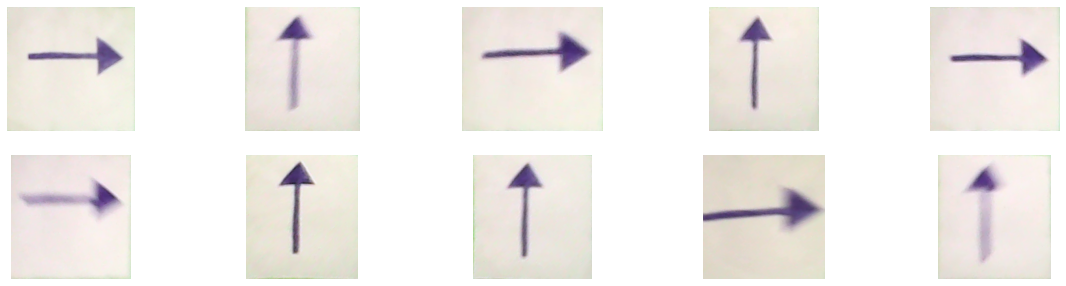

In [35]:
plt.figure(figsize=(20, 5))
for ind in range(len(images)):
  plt.subplot(2, 5, ind+1)
  plt.imshow(show_files(view_from_above(images[ind])))
  plt.axis('off')
plt.show ()